# Data Science Project




---

Meriem Hafid

Thomas Konigkramer

Tomas Somoza

---



>[Data Science Project](#scrollTo=ZXNX8LtvemHD)

>>[Introduction](#scrollTo=XBLpmkhJEFop)

>>[Package Imports & Home Directory](#scrollTo=ErtsY9FVozFA)

>>[Exploratory Data Analysis](#scrollTo=OSiXIjveDu5i)

>>>[3.1. Datasets](#scrollTo=B6ixoP40Du5j)

>>>[3.2. Response Variable: Failure](#scrollTo=7KTaqH0tEr52)

>>>[3.3. Explanatory Variables: Product Codes & Attributes](#scrollTo=y0YjAOduFC6b)

>>>[3.4. Explanatory Variables: Loading & Measurements](#scrollTo=eziMK85mFC6d)

>>>[3.5. Missing (NaN) Values](#scrollTo=m6T1zOnXFC6d)

>>>[3.6. Feature Engineering](#scrollTo=_qQZX5AfFC6f)

>>>>[Normalising data](#scrollTo=CvQ0_S28FC6f)

>>>>[Missing (NaN) Values Fill](#scrollTo=ZToVV8LmFC6f)

>>>>[Imbalanced Data](#scrollTo=_ksPLySLFC6g)

>>>>[Removing outliers](#scrollTo=pMg_hqERFC6g)

>>>[3.7. Standardising Variables](#scrollTo=bBLMA9VgFC6i)

>>>[Feature selection](#scrollTo=z3tp8h1nWtnD)

>>>>[Feature selection with logistic regression](#scrollTo=QohGRD-CG1FW)

>>>>[Recursive feature elimination with cross-validation](#scrollTo=eX1mscObbEPI)

>>[Champion Model: Logistic Regression Model](#scrollTo=s5VV5m0Yh8Fk)

>>[Challenger Model 1: Random forest](#scrollTo=DEegFJHaxJ0f)

>>[Challenger Model 2: XGBOOST](#scrollTo=8Wil6qeHibDV)

>>[Challenger Model 3: Support Machine Vector (SVM)](#scrollTo=1i6hsSX2ibLx)

>>[Challenger Model 4: NN](#scrollTo=AY_1pafeuwh2)





---



## 1. Introduction

We found an interesting [kaggle dataset](https://www.kaggle.com/competitions/tabular-playground-series-aug-2022/overview) on which we decided to perform our analysis and data modelling. We are considering a fictional company, *Keep it Dry*, which is aiming to improve one of its best-selling products called *Super Soaker*. This is an industrial product used in factories to absorb an array of spills and leaks - in short, it is an industrial spounge. We are given the test results of various product prototypes in a train dataset, and wish to build a statistical model to predict product failures in a corresponding test dataset.

We will do this within the specified framework of the project, which is to begin with a *Champion Model*, and then comparing it to four additional *Challenger Models*.   

**NB:**The analysis and comments in this notebook are merely a supplement to the code and final PDF document.

## 2. Package Imports & Home Directory



Below we import various modules/libraries to be used in our project.

* **pandas:** data analysis and manipulation
* **numpy:** mathematical tools and functions
* **matplotlib.pyplot:** statistical plotting tool
* **missingno:** data visualisation tool aimed at explanining missing values

* **sklearn:**


We also set the working directory to a shared google drive repository to centralise all our work and resources.

In [ ]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
from matplotlib import pyplot as plt
import missingno
import scipy.stats as stats
import xgboost

from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score ,roc_curve,auc, make_scorer, f1_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Input, Add, Dense, Activation, Dropout, BatchNormalization
from keras.utils import plot_model

from imblearn.combine import SMOTETomek

**NB:** We set out home directory to a shared Google drive folder. If used elsewhere, change the below to where project zip file is saved locally.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
path = '/content/drive/MyDrive/Data Science Project 2022'
os.chdir(path)

Mounted at /content/drive


## 3. Exploratory Data Analysis

We have split our EDA into separate parts. We begin with an initial analysis of the data to help us in our interpretation of the models we will build and compare. Following this, we fill-in missing values in our data, deal with the evident imbalance of output values, and further transform and clean the data.

### 3.1. Datasets

We have two datasets to work with:
* **train:** contains the train dataset which will be used to build our model. There are 26570 observations.
* **test:** contains the test dataset for which we will be predicting missing response variable. We have 20775 observations to predict.

In both these datasets, we have 24 explanatory variables (after removing the *id* field which is simply a count column and not providing us with any useful information). Most of the variables are numerical - either float or integer values - with some string variables.

In [ ]:
# create dataset dataframes
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# remove id field
train = train.drop('id', axis = 1)
test = test.drop('id', axis = 1)
# display
display(train.head(10))
display(test.head(10))
# for later use - combined dataframe
all = pd.concat([train,test])
# display(all)

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0
5,A,75.35,material_7,material_8,9,5,11,4,0,17.564,...,10.622,14.904,19.107,13.327,15.354,19.251,NaN,17.625,832.902,0
6,A,161.71,material_7,material_8,9,5,12,2,4,17.303,...,11.370,17.714,19.924,11.560,16.653,17.734,NaN,16.637,684.438,1
7,A,177.92,material_7,material_8,9,5,4,8,8,17.062,...,10.254,16.449,20.478,12.207,15.624,16.968,15.176,17.231,684.000,1
8,A,109.50,material_7,material_8,9,5,9,6,5,18.111,...,11.557,15.965,19.604,14.091,15.674,13.327,13.535,15.408,NaN,0
9,A,98.72,material_7,material_8,9,5,10,4,7,18.945,...,10.384,15.237,18.427,12.635,14.318,14.327,12.867,NaN,NaN,0


,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,F,119.57,material_5,material_6,6,4,6,9,6,19.305,...,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612
1,F,113.51,material_5,material_6,6,4,11,8,0,17.883,...,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037
2,F,112.16,material_5,material_6,6,4,8,12,4,18.475,...,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995
3,F,112.72,material_5,material_6,6,4,8,11,10,16.518,...,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301
4,F,208.00,material_5,material_6,6,4,14,16,8,17.808,...,19.141,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044
5,F,80.67,material_5,material_6,6,4,10,11,7,17.576,...,19.773,13.446,18.331,16.218,11.632,12.829,16.238,15.605,15.975,820.830
6,F,91.90,material_5,material_6,6,4,6,18,11,14.708,...,16.909,10.488,16.801,18.527,13.089,16.435,16.079,15.900,NaN,584.913
7,F,143.64,material_5,material_6,6,4,16,7,4,18.909,...,19.200,11.097,NaN,18.770,11.055,16.077,16.126,13.011,16.830,701.468
8,F,71.94,material_5,material_6,6,4,7,9,7,15.398,...,18.367,12.280,17.959,17.404,10.713,17.204,16.647,14.800,16.174,594.924
9,F,95.46,material_5,material_6,6,4,14,15,7,17.886,...,19.081,10.283,NaN,18.373,13.604,15.573,14.948,16.694,NaN,628.040


In [ ]:
# shape of data - to determine no. of variables and observations
count_train = train.shape[0]
display(train.shape)
display(test.shape)

(26570, 25)

(20775, 24)

In [ ]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26570 entries, 0 to 26569
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_code    26570 non-null  object 
 1   loading         26320 non-null  float64
 2   attribute_0     26570 non-null  object 
 3   attribute_1     26570 non-null  object 
 4   attribute_2     26570 non-null  int64  
 5   attribute_3     26570 non-null  int64  
 6   measurement_0   26570 non-null  int64  
 7   measurement_1   26570 non-null  int64  
 8   measurement_2   26570 non-null  int64  
 9   measurement_3   26189 non-null  float64
 10  measurement_4   26032 non-null  float64
 11  measurement_5   25894 non-null  float64
 12  measurement_6   25774 non-null  float64
 13  measurement_7   25633 non-null  float64
 14  measurement_8   25522 non-null  float64
 15  measurement_9   25343 non-null  float64
 16  measurement_10  25270 non-null  float64
 17  measurement_11  25102 non-null 

None

In [ ]:
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20775 entries, 0 to 20774
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_code    20775 non-null  object 
 1   loading         20552 non-null  float64
 2   attribute_0     20775 non-null  object 
 3   attribute_1     20775 non-null  object 
 4   attribute_2     20775 non-null  int64  
 5   attribute_3     20775 non-null  int64  
 6   measurement_0   20775 non-null  int64  
 7   measurement_1   20775 non-null  int64  
 8   measurement_2   20775 non-null  int64  
 9   measurement_3   20446 non-null  float64
 10  measurement_4   20366 non-null  float64
 11  measurement_5   20267 non-null  float64
 12  measurement_6   20151 non-null  float64
 13  measurement_7   20055 non-null  float64
 14  measurement_8   19929 non-null  float64
 15  measurement_9   19871 non-null  float64
 16  measurement_10  19708 non-null  float64
 17  measurement_11  19639 non-null 

None

### 3.2. Response Variable: *Failure*

Our response variable is *failure*, which is a binary variable describing a pass (0) or failure (1). This is an unusual form for this binary data to be in, which generally describes a pass or failure with opposite numbers to this.

We plot the train dataset's response variables and see that there is a large discrepancy between passes and failures. In this case, there are many more passes than failures. Evidently we are working with an imbalanced dataset, which could result in poor performance on the minority class, viz. failures. We will address this problem below.

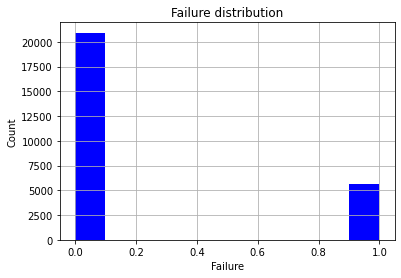

In [ ]:
y = train[['failure']]
y.hist(color = 'b')
plt.xlabel("Failure")
plt.ylabel("Count")
plt.title("Failure distribution")
plt.savefig("imb.png", dpi=300)

In [ ]:
#@title
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26570 entries, 0 to 26569
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_code    26570 non-null  object 
 1   loading         26320 non-null  float64
 2   attribute_0     26570 non-null  object 
 3   attribute_1     26570 non-null  object 
 4   attribute_2     26570 non-null  int64  
 5   attribute_3     26570 non-null  int64  
 6   measurement_0   26570 non-null  int64  
 7   measurement_1   26570 non-null  int64  
 8   measurement_2   26570 non-null  int64  
 9   measurement_3   26189 non-null  float64
 10  measurement_4   26032 non-null  float64
 11  measurement_5   25894 non-null  float64
 12  measurement_6   25774 non-null  float64
 13  measurement_7   25633 non-null  float64
 14  measurement_8   25522 non-null  float64
 15  measurement_9   25343 non-null  float64
 16  measurement_10  25270 non-null  float64
 17  measurement_11  25102 non-null 

None

In [ ]:
#@title
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20775 entries, 0 to 20774
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_code    20775 non-null  object 
 1   loading         20552 non-null  float64
 2   attribute_0     20775 non-null  object 
 3   attribute_1     20775 non-null  object 
 4   attribute_2     20775 non-null  int64  
 5   attribute_3     20775 non-null  int64  
 6   measurement_0   20775 non-null  int64  
 7   measurement_1   20775 non-null  int64  
 8   measurement_2   20775 non-null  int64  
 9   measurement_3   20446 non-null  float64
 10  measurement_4   20366 non-null  float64
 11  measurement_5   20267 non-null  float64
 12  measurement_6   20151 non-null  float64
 13  measurement_7   20055 non-null  float64
 14  measurement_8   19929 non-null  float64
 15  measurement_9   19871 non-null  float64
 16  measurement_10  19708 non-null  float64
 17  measurement_11  19639 non-null 

None

### 3.3. Explanatory Variables: Product Codes & Attributes

We begin our analysis of the explanatory variables, focusing first on the product codes and attributes, as these are variables which seem to describe the prototypes being tested, and are likely to be categorical variables requiring encoding. The other variables contain measurements, which are associated to the performance of the product.

A comprehensive description is found in the main document.

,product_code,attribute_0,attribute_1,attribute_2,attribute_3,count
0,A,material_7,material_8,9,5,5100
1,B,material_5,material_5,8,8,5250
2,C,material_7,material_8,5,8,5765
3,D,material_7,material_5,6,6,5112
4,E,material_7,material_6,6,9,5343


,product_code,attribute_0,attribute_1,attribute_2,attribute_3,count
0,F,material_5,material_6,6,4,5422
1,G,material_5,material_6,9,7,5107
2,H,material_7,material_7,7,9,5018
3,I,material_7,material_5,9,5,5228


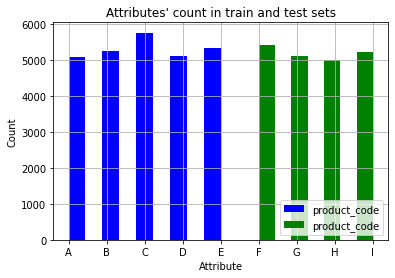

In [ ]:
#@title
# train data
products_train = train[['product_code','attribute_0','attribute_1','attribute_2','attribute_3']]
products_train = products_train.drop_duplicates().reset_index(drop=True)
# counting
product_count = []
for product_code in products_train['product_code']:
  product_count.append(len(train['product_code'][train.product_code == product_code].sum()))
products_train['count'] = product_count

# test data
products_test = test[['product_code','attribute_0','attribute_1','attribute_2','attribute_3']]
products_test = products_test.drop_duplicates().reset_index(drop=True)
# counting
product_count = []
for product_code in products_test['product_code']:
  product_count.append(len(test['product_code'][test.product_code == product_code].sum()))
products_test['count'] = product_count

# concatenation
products = pd.concat([products_train, products_test], axis = 0)

# display(products)
display(products_train)
display(products_test)

#plots the histogram
train['product_code'].hist(bins=9, color = 'b', legend=True)
test['product_code'].hist(bins=7, color = 'g', legend=True)
plt.ylabel("Count")
plt.xlabel("Attribute")
plt.legend(loc="lower right")
plt.title("Attributes' count in train and test sets")
# plt.show()
plt.savefig("attr.png", dpi=300)


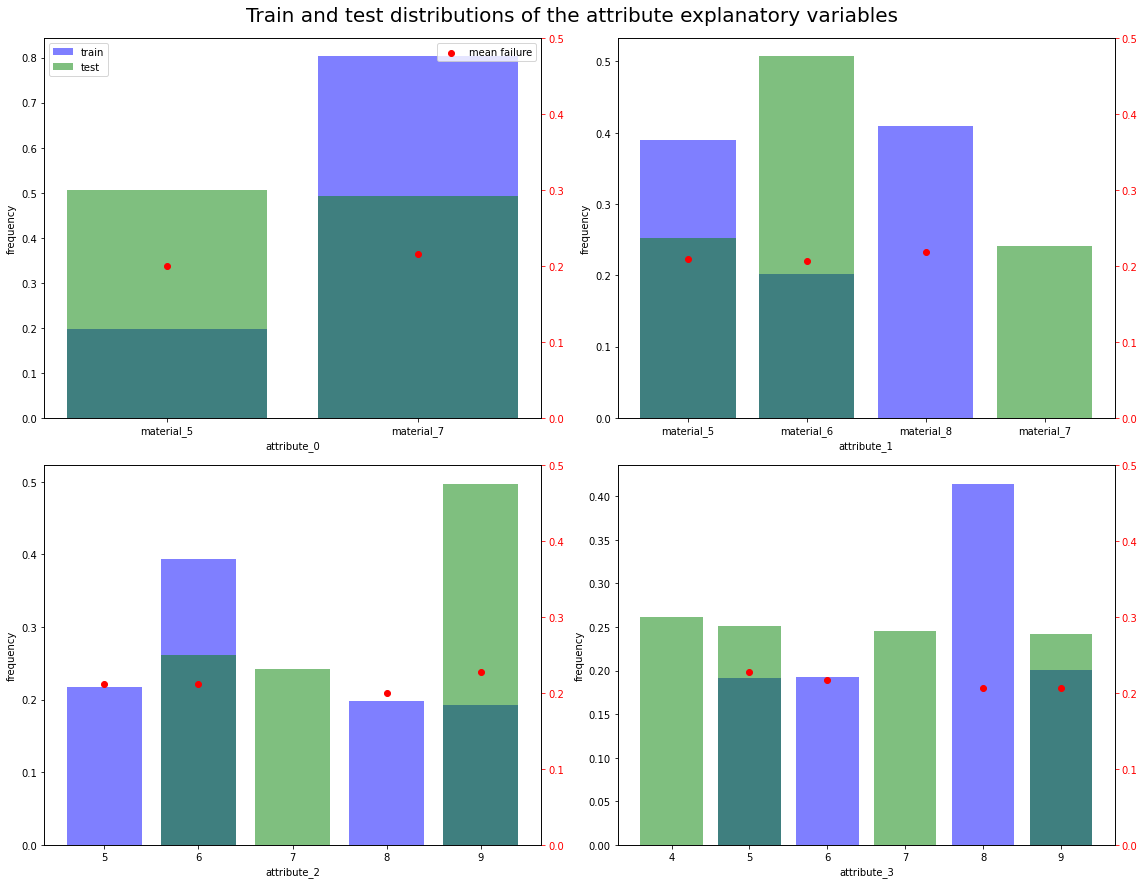

In [ ]:
attributes = products.drop(columns = ['product_code', 'count'])
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
for f, ax in zip(attributes, axes.ravel()):
    # count for all train data
    temp1 = train.failure.groupby(train[f]).agg(['mean', 'size'])
    # count for all test data
    temp2 = test[f].value_counts()
    # temp3 for additional rows to ensure complete index in temp1 - may give weird order, but will label correctly
    temp3 = pd.DataFrame({'mean': [np.nan], 'size': [0]}, index = temp2.index)
    # include zero count for values in test and not train
    temp1 = pd.concat([temp1, temp3], ignore_index=False)
    # display(temp1)
    ax.bar(temp1.index, temp1['size'] / len(train), alpha=0.5, label='train', color = 'b')
    ax.bar(temp2.index, temp2 / len(test), alpha=0.5, label='test',color = 'g')
    ax.set_xlabel(f)
    ax.set_ylabel('frequency')

    ax2 = ax.twinx()

    ax2.scatter(temp1.index, temp1['mean'],
                color='r', label='mean failure')
    ax2.set_ylim(0, 0.5)
    ax2.tick_params(axis='y', colors='r')
    if ax == axes[0, 0]: ax2.legend(loc='upper right')

axes[0, 0].legend()

plt.tight_layout()
plt.suptitle('Train and test distributions of the attribute explanatory variables', fontsize=20, y=1.02)
plt.savefig("dist1.png", dpi=300)
plt.show()
del temp1, temp2, temp3

In [ ]:
### encoding dummy variables

#categoricals = list(train.select_dtypes(exclude='number').columns)
categoricals = ['attribute_0', 'attribute_1']

# display(train[['attribute_0', 'attribute_1']])
# drop_first = False not set because we do not have a binary option
one_hot = pd.get_dummies(train[categoricals])
# Join the encoded df and drop old field
train_enc = train.join(one_hot)
train_enc = train_enc.drop(categoricals, axis = 1)
# drop product code as explained above
train_enc = train_enc.drop(['product_code'], axis = 1)
# display(train_enc)

one_hot2 = pd.get_dummies(test[['attribute_0','attribute_1']])
# Join the encoded df and drop old field
test_enc = test.join(one_hot2)
test_enc = test_enc.drop(categoricals,axis = 1)
# drop product code as explained above
test_enc = test_enc.drop(['product_code'], axis = 1)
# display(test_enc)

del one_hot, one_hot2

### 3.4. Explanatory Variables: Loading & Measurements

We complete our analysis of the explanatory variables by looking at the *loading* and *measurement* variables. We use figures from above in our understanding of what these variables portray.



<ipython-input-13-ab858672ed7c>:20: RuntimeWarning: invalid value encountered in true_divide
  ax2.scatter((bins[1:] + bins[:-1]) / 2, failures / total, color='r', s=10, label='failure probability')


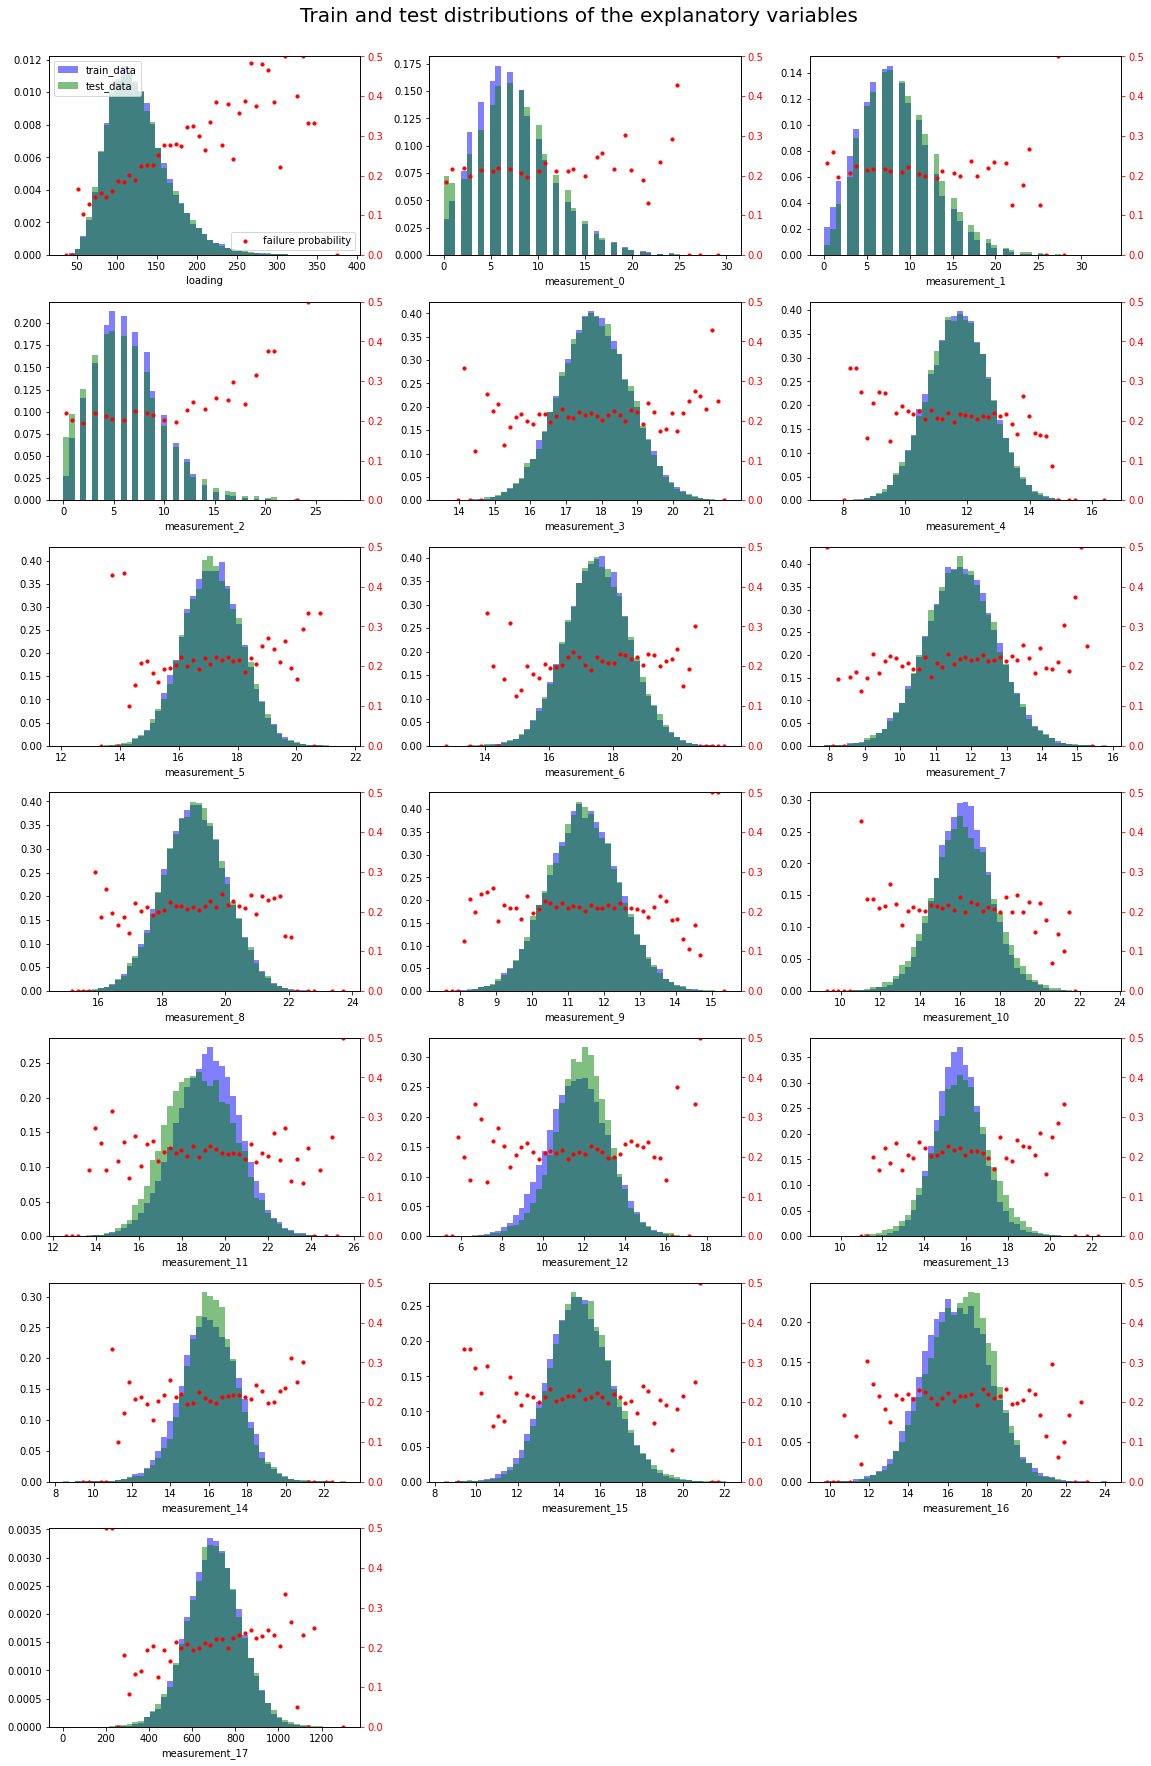

In [ ]:
# distributions

#continuous = list(train.select_dtypes(include='number').columns)
continuous = ['loading','measurement_0','measurement_1','measurement_2','measurement_3','measurement_4','measurement_5','measurement_6','measurement_7','measurement_8','measurement_9','measurement_10','measurement_11','measurement_12','measurement_13','measurement_14','measurement_15','measurement_16','measurement_17']
measurements = train[continuous]

fig, axes = plt.subplots(7, 3, figsize=(16,24))
for f, ax in zip(measurements, axes.ravel()):
    lower = min(train[f].min(), test[f].min())
    upper = max(train[f].max(), test[f].max())
    bins = np.linspace(lower, upper, 50)
    ax.hist(train[f], bins=bins, alpha=0.5, density=True, label='train_data', color = 'b')
    ax.hist(test[f], bins=bins, alpha=0.5, density=True, label='test_data', color = 'g')
    ax.set_xlabel(f)
    if ax == axes[0, 0]: ax.legend(loc='upper left')

    ax2 = ax.twinx()
    total, _ = np.histogram(train[f], bins=bins)
    failures, _ = np.histogram(train[f][train.failure == 1], bins=bins)
    ax2.scatter((bins[1:] + bins[:-1]) / 2, failures / total, color='r', s=10, label='failure probability')
    ax2.set_ylim(0, 0.5)
    ax2.tick_params(axis='y', colors='r')
    if ax == axes[0, 0]: ax2.legend(loc='lower right')

# delete extra subplots
fig.delaxes(axes[6][1])
fig.delaxes(axes[6][2])

plt.tight_layout()
plt.suptitle('Train and test distributions of the explanatory variables', fontsize=20, y=1.02)
plt.savefig("dist2.png", dpi=300)
plt.show()

### 3.5. Missing (NaN) Values

We determine whether there are missing values and we fill them. From the figure directly below it is clear that we are missing values in our datasets that will need to be filled.  

Product code and attributes have no missing information. Additionally, *measurement_0* to *measurment_2* are also not missing any information. Hence, all the string and integer variables are not missing data.

Looking at the variables with missing data, we see that approximately 3% of all the fields are empty, which does not seem signficant, but looking closer we see that approximately 54% of our observations are missing at least one data field. Excluding observations with missing data would thus halve our information and is not feasible. We need to fill this data so that accurate models can be built.

.

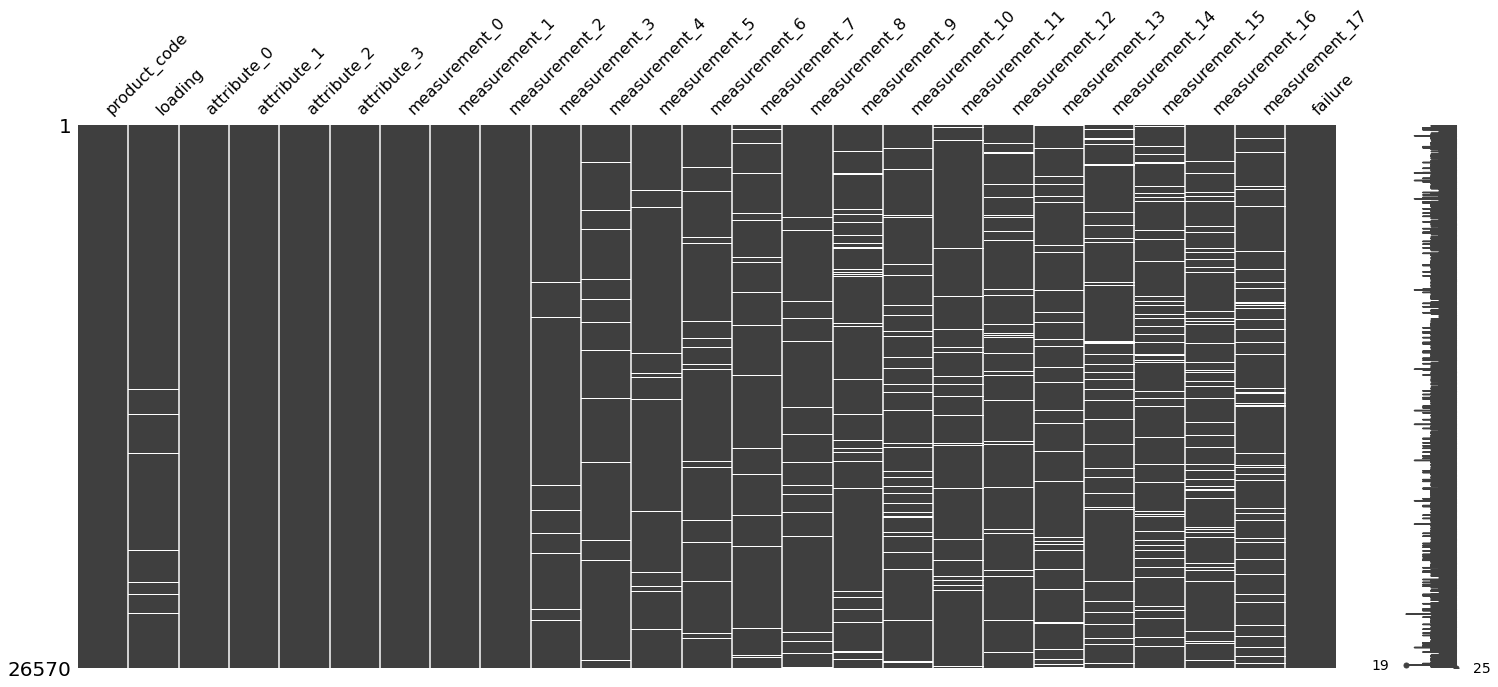

In [ ]:
missingno.matrix(df=train)
plt.savefig("missing.png", dpi=300)

In [ ]:
missing_train = pd.concat([train.isna().sum().rename('NaN Count'), (train.isna().sum()/count_train*100).rename('NaN Prop. (%)')], axis=1)
display(missing_train.T)

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
NaN Count,0.0,250.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,381.000000,...,1227.00000,1300.000000,1468.000000,1601.000000,1774.000000,1874.000000,2009.000000,2110.000000,2284.000000,0.0
NaN Prop. (%),0.0,0.940911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.433948,...,4.61799,4.892736,5.525028,6.025593,6.676703,7.053067,7.561159,7.941287,8.596161,0.0


In [ ]:
missing_test = pd.concat([test.isna().sum().rename('NaN Count'), (test.isna().sum()/count_train*100).rename('NaN Prop. (%)')], axis=1)
display(missing_test.T)

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
NaN Count,0.0,223.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,329.000000,...,846.000000,904.000000,1067.000000,1136.000000,1240.000000,1303.000000,1440.000000,1542.000000,1678.000000,1740.000000
NaN Prop. (%),0.0,0.839292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.238239,...,3.184042,3.402333,4.015807,4.275499,4.666918,4.904027,5.419646,5.803538,6.315393,6.548739


In [ ]:
print(f'Missing values in the train dataset: %.3f%%' % (100*train.isna().sum().sum()/(train.shape[0]*train.shape[1])))
print(f'Missing values in the test dataset: %.3f%%' % (100*test.isna().sum().sum()/(test.shape[0]*test.shape[1])))

# display(y)
# 0 = pass, 1 = failure
rates = train.failure.value_counts() / len(train)
pass_rate = rates[0]
failure_rate = rates[1]
print(f"\nPass (0) vsfailure (1) rate in our training data: \n{rates} \n")
print(f"Proportion of observations in our total dataset that have at least one missing explanatory variable: {all[measurements.columns].isna().any(axis=1).sum() / len(all):.0%}")

Missing values in the train dataset: 3.052%
Missing values in the test dataset: 3.151%

Pass (0) vsfailure (1) rate in our training data: 
0    0.787392
1    0.212608
Name: failure, dtype: float64 

Proportion of observations in our total dataset that have at least one missing explanatory variable: 54%


The missing values may be an early indicator of failure. We test this by calculating the coniditional product failure rate given the measurement that is missing and comparing it to the product failure rate (which is 0.212608).

In [ ]:
# conditional product failure rate given the measurement is missing E[product fails | measurement is missing] and compare it to the unconditional product failure rate, which is 0.212608.
total = train.isna().sum().sum()
fail = train.failure
display(fail)

0        0
1        0
2        0
3        0
4        0
        ..
26565    0
26566    0
26567    0
26568    0
26569    0
Name: failure, Length: 26570, dtype: int64

variable           fail   miss   failure rate       z    p-value
loading         :   44 /  250 = 0.176          -1.41      0.157
measurement_3   :   61 /  381 = 0.160          -2.50      0.012
measurement_4   :  128 /  538 = 0.238           1.43      0.151
measurement_5   :  172 /  676 = 0.254           2.66      0.008
measurement_6   :  171 /  796 = 0.215           0.15      0.879
measurement_7   :  197 /  937 = 0.210          -0.18      0.860
measurement_8   :  218 / 1048 = 0.208          -0.36      0.716
measurement_9   :  283 / 1227 = 0.231           1.54      0.123
measurement_10  :  277 / 1300 = 0.213           0.04      0.967
measurement_11  :  311 / 1468 = 0.212          -0.07      0.944
measurement_12  :  356 / 1601 = 0.222           0.95      0.340
measurement_13  :  373 / 1774 = 0.210          -0.24      0.809
measurement_14  :  413 / 1874 = 0.220           0.82      0.411
measurement_15  :  430 / 2009 = 0.214           0.16      0.876
measurement_16  :  436 / 2110 = 0.207  

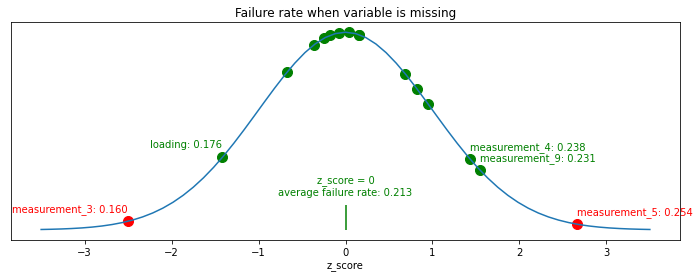

In [ ]:
# Start by plotting the bell curve
plt.figure(figsize=(12, 4))
z_ticks = np.linspace(-3.5, 3.5, 61)
pdf = scipy.stats.norm.pdf(z_ticks)
plt.plot(z_ticks, pdf)



# Calculate the conditional failure rate for every missing feature
# Print the values and plot them
print('variable           fail   miss   failure rate       z    p-value')
for f in train.columns:
    if train[f].isna().sum() > 0: # excludes all variables that never have a missing value
        total = train[f].isna().sum()
        fail = train[train[f].isna()].failure.sum()
        z = (fail / total - failure_rate) / (np.sqrt(failure_rate * (1-failure_rate)) / np.sqrt(total))
        plt.scatter([z], [scipy.stats.norm.pdf(z)], c='r' if abs(z) > 2 else 'g', s=100)
        print(f"{f:15} : {fail:4} / {total:4} = {fail/total:.3f}          {z:5.2f}      {2*scipy.stats.norm.cdf(-abs(z)):.3f}")
        if abs(z) > 1: plt.annotate(f"{f}: {fail / total:.3f}",
                                    (z, scipy.stats.norm.pdf(z)),
                                    xytext=(0,10),
                                    textcoords='offset points', ha='left' if z > 0 else 'right',
                                    color='r' if abs(z) > 2 else 'g')

# Annotage the center (z=0)
plt.vlines([0], 0, 0.05, color='g')
plt.annotate(f"z_score = 0\naverage failure rate: {failure_rate:.3f}",
                                    (0, 0.05),
                                    xytext=(0,10),
                                    textcoords='offset points', ha='center',
                                    color='g')
plt.title('Failure rate when variable is missing')
plt.yticks([])
plt.xlabel('z_score')
plt.savefig("zsco.png", dpi=300)
plt.show()

Looking at the above diagram, when measurement_3 is missing, the failure rate is 0.160 (much lower than average).
When measurement_5 is missing, the failure rate is 0.254 (much higher than average). We create dummy variables to record when these variables had missing data as another predicting variable for failure of the product.

In [ ]:
# create dummy variables for when measurement_3 and measurement_5 have missing (nan) values
train_enc['measurement_3_nan'] = pd.Series([1 if b else 0 for b in train_enc['measurement_3'].isna()])
train_enc['measurement_5_nan'] = pd.Series([1 if b else 0 for b in train_enc['measurement_5'].isna()])
# display(train_enc)

In [ ]:
test_enc['measurement_3_nan'] = pd.Series([1 if b else 0 for b in test_enc['measurement_3'].isna()])
test_enc['measurement_5_nan'] = pd.Series([1 if b else 0 for b in test_enc['measurement_5'].isna()])

### 3.6. Feature Engineering

#### Normalising data

Before addressing the data imbalances and missing values, we need to normalise our data. We are using the Box-Cox Transformation. The procedure consists of identifying an appropriate exponent λ to transform the data into a “normal shape”. The Lambda value indicates the power to which all data should be raised λ∈[-5,5].

The Box-Cox Power transformation only works if all the data is strictly positive. Hence, we are using the Yeo-Johnson transformation, which is an adaptation of Box-Cox transformation that can also be used without reconstructions of our values. Of course normalisation is only necessary for the non-normal variables: *loading*, *measurement_0*, *measurement_1* and *measurement_2*.

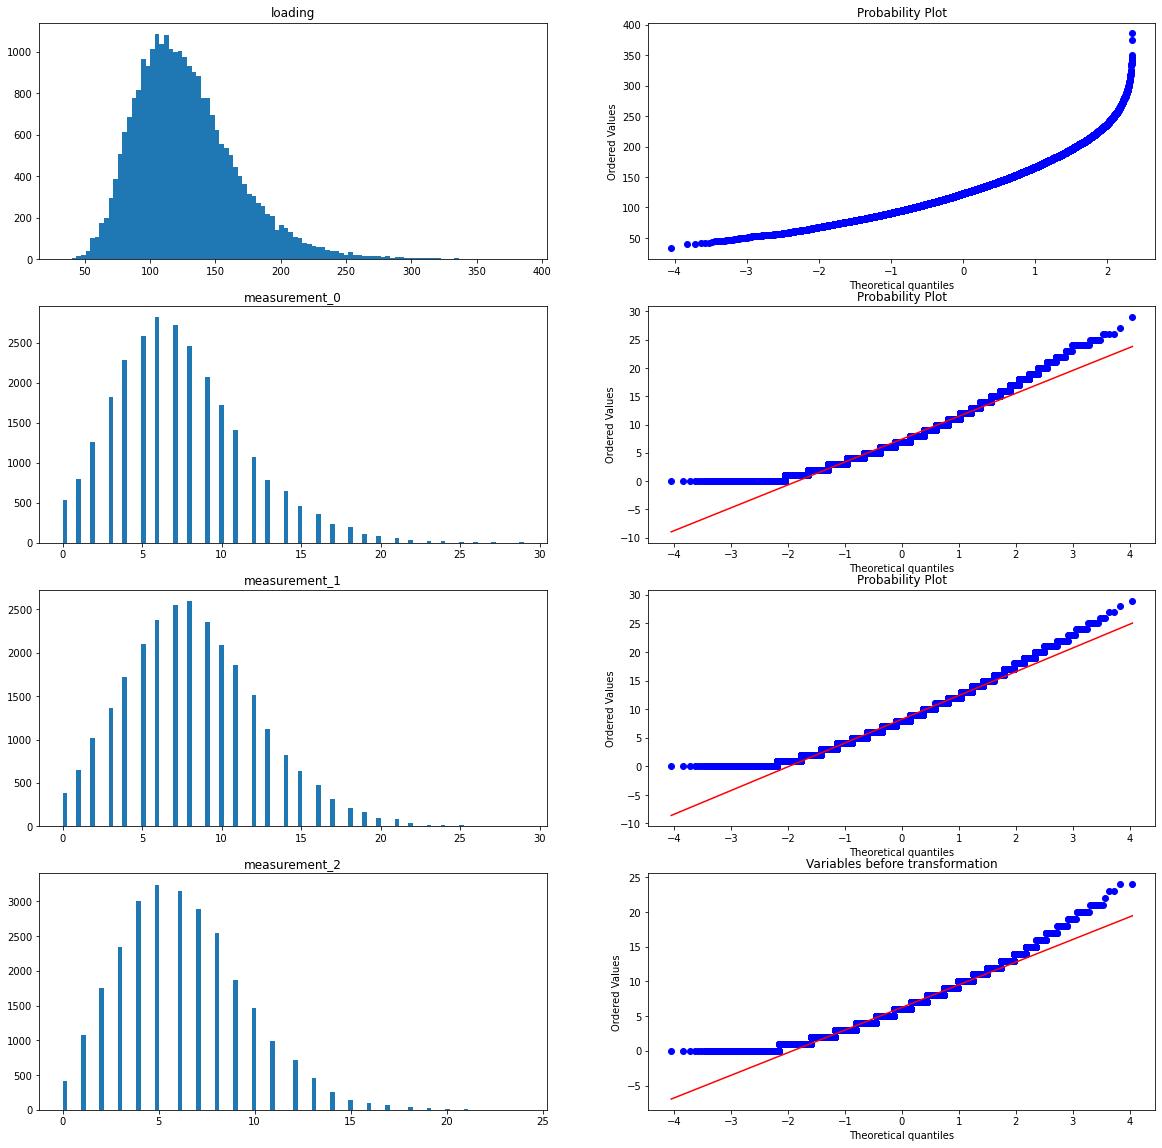

In [ ]:
cols_to_transform = ['loading', 'measurement_0', 'measurement_1', 'measurement_2']
num_cols = len(cols_to_transform)
figure = plt.figure(figsize=(20, 20))
for i in range(num_cols):
    feature = cols_to_transform[i]
    plt.subplot(num_cols, 2, 2*i+1)
    plt.hist(train_enc[feature], bins=100)
    plt.title(f'{feature}')
    plt.subplot(num_cols, 2, 2*i+2)
    stats.probplot(train_enc[feature], dist='norm', plot = plt)
# figure.tight_layout(h_pad=1.0, w_pad=1.0)
plt.title("Variables before transformation")
plt.savefig("norma.png", dpi=300)
plt.show()

In [ ]:
transformer = PowerTransformer(method='yeo-johnson', standardize = False)
#cols_to_transform = ['loading', 'measurement_0', 'measurement_1', 'measurement_2']
transformer.fit(train_enc[cols_to_transform])
normal_train = transformer.transform(train_enc[cols_to_transform])
normal_train = pd.DataFrame(normal_train, columns = cols_to_transform)
train_enc[cols_to_transform] = normal_train

In [ ]:
normal_test = transformer.transform(test_enc[cols_to_transform]) #Transforming the test_imp data
normal_test = pd.DataFrame(normal_test, columns = cols_to_transform)
test_enc[cols_to_transform] = normal_test

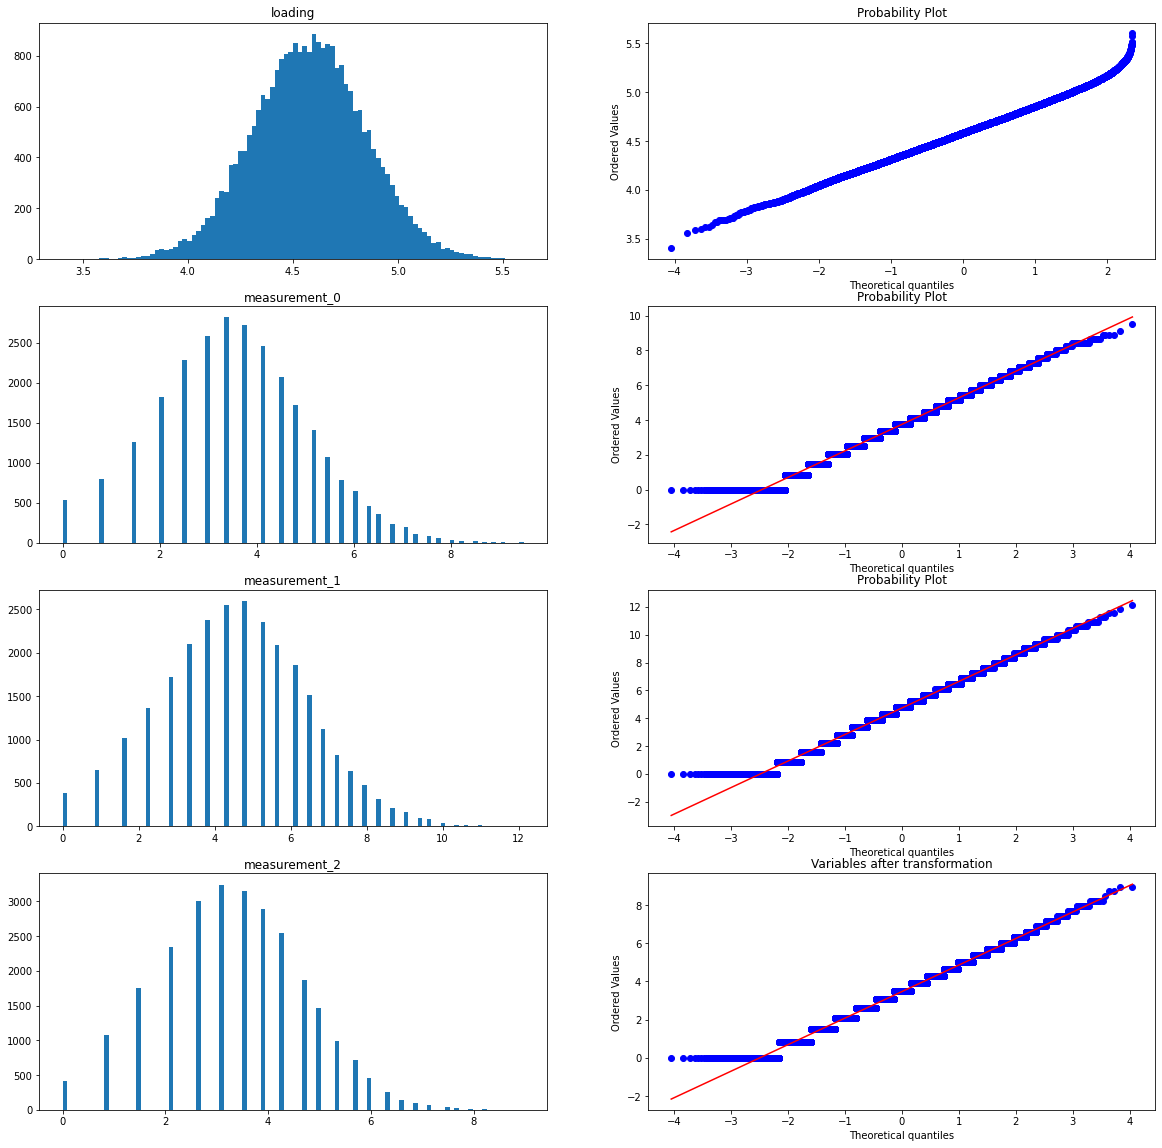

In [ ]:
num_cols = len(cols_to_transform)
figure = plt.figure(figsize=(20, 20))
for i in range(num_cols):
    feature = cols_to_transform[i]
    plt.subplot(num_cols, 2, 2*i+1)
    plt.hist(train_enc[feature], bins=100)
    plt.title(f'{feature}')
    plt.subplot(num_cols, 2, 2*i+2)
    stats.probplot(train_enc[feature], dist='norm', plot = plt)
# figure.tight_layout(h_pad=1.0, w_pad=1.0)
plt.title("Variables after transformation")
plt.savefig("norma2.png", dpi=300)
plt.show()

#### Missing (NaN) Values Fill

Now that our dataset has dummy variables and normalised, we can move on to the KNN Imputation (the chosen method for filling our missing data). We are setting the parameter ‘n_neighbors’ as 5. So, the missing values will be replaced by the mean value of 5 nearest neighbors measured by Euclidean distance.

In [ ]:
%%time
failure_list = train['failure']

# removing failure from train
train_ = train_enc.drop(['failure'], axis = 1)
test_ = test_enc

imputer_dist = KNNImputer(n_neighbors = 5, weights = 'distance',metric = 'nan_euclidean')
train_imp = pd.DataFrame(imputer_dist.fit_transform(train_),columns = train_.columns)
test_imp = pd.DataFrame(imputer_dist.fit_transform(test_),columns = test_.columns)

CPU times: user 1min 11s, sys: 3.29 s, total: 1min 14s
Wall time: 1min 7s


In [ ]:
train_imp.head()

,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,...,measurement_15,measurement_16,measurement_17,attribute_0_material_5,attribute_0_material_7,attribute_1_material_5,attribute_1_material_6,attribute_1_material_8,measurement_3_nan,measurement_5_nan
0,4.198782,9.0,5.0,3.780668,4.794218,2.602745,18.040,12.518,15.748,19.292,...,13.034,14.684,764.100,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,4.251072,9.0,5.0,6.011688,2.226638,2.089140,18.213,11.540,17.717,17.893,...,14.395,15.631,682.057,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,4.224600,9.0,5.0,5.436950,0.871433,3.072373,18.057,11.652,16.738,18.240,...,14.094,17.946,663.376,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,4.407961,9.0,5.0,5.729175,1.590916,3.508327,17.295,11.188,18.576,18.339,...,16.154,17.172,826.282,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,4.963665,9.0,5.0,4.489509,1.590916,4.304299,19.346,12.950,16.990,15.746,...,13.153,16.412,579.885,0.0,1.0,0.0,0.0,1.0,0.0,0.0


#### Imbalanced Data

With normalised and complete data, we can address the imbalanced data.
We will apply an over-sampler using SMOTE and cleaning using Tomek links.
SMOTETomek is a combination of two techniques for dealing with imbalanced datasets: SMOTE (Synthetic Minority Oversampling Technique) and Tomek Links. We describe this in our report more fully.

At the end we see we now have balanced data.

In [ ]:
print(f'Original failure column shape {y.shape}') # y = train[['failure']]
print(f'Original train dataset shape {train_imp.shape}')
# Original dataset shape Counter({1: 900, 0: 100})
smt = SMOTETomek(random_state=42)
train_resampled, y_resampled = smt.fit_resample(train_imp, y)
print(f'Resampled failure column shape {y_resampled.shape}')
print(f'Resampled train dataset shape {train_resampled.shape}')

Original failure column shape (26570, 1)
Original train dataset shape (26570, 28)
Resampled failure column shape (41716, 1)
Resampled train dataset shape (41716, 28)


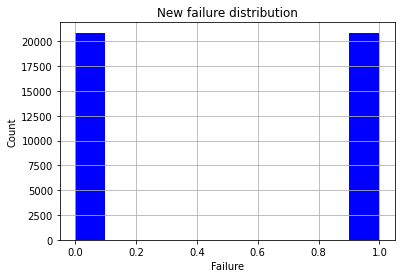

In [ ]:
y_resampled.hist(color = 'b')
plt.xlabel("Failure")
plt.ylabel("Count")
plt.title("New failure distribution")
plt.savefig("imb1.png", dpi=300)

#### Removing outliers

The distribution of values in both data are Gaussian or, we can use the standard deviation of the sample as a cut-off for identifying outliers.
we will remove outliers by calculating upper boundary and lower boundary and taking 3 standard deviation from the mean of the values.

Normal distribution has the property that,

*   68% of the data falls within one standard deviation of the mean.
*   95% of the data falls within two standard deviations of the mean.
*   99.7% of the data falls within three standard deviations of the mean.


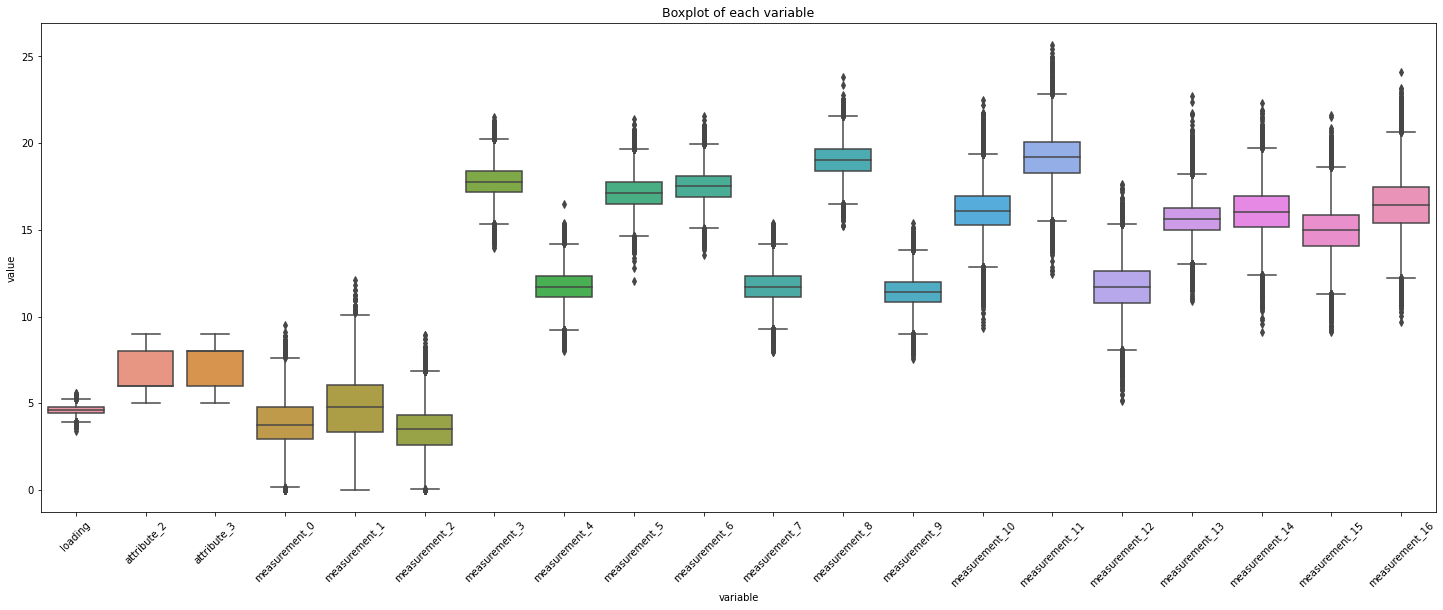

In [ ]:
df = pd.DataFrame(data = train_resampled, columns = train_resampled.columns[0:20])
plt.figure(figsize=(25,9))
sns.boxplot(x="variable", y="value", data=pd.melt(df)).set_title('Boxplot of each variable',size=12.5)
plt.xticks(rotation=45)
plt.savefig("outl1.png", dpi=300)
plt.show()

We see that there are many outliers. We create functions to re-adjust these outlying values to the previously discussed boundary values.

In [ ]:
def find_boundaries(df, feature):
  """
  Function to define upper and lower boundaries.

  """
  upper_boundary = df[feature].mean() + 3 * df[feature].std()
  lower_boundary = df[feature].mean() - 3 * df[feature].std()
  return upper_boundary, lower_boundary

In [ ]:
def check_outliers(dataframe, col_name):
    """
    Function that uses the already found boundaries to check outliers.

    """
    lower_boundary, upper_boundary = find_boundaries(dataframe, col_name)
    if dataframe[(dataframe[col_name] > upper_boundary) | (dataframe[col_name] < lower_boundary)].any(axis=None):
        return True
    else:
        return False

In [ ]:
train_final = train_resampled.copy()
for col in continuous:
    upper_l, lower_l = find_boundaries(train_final, col)
    train_final[col] = np.where(train_final[col] > upper_l, upper_l, np.where(train_final[col] < lower_l, lower_l, train_final[col]))

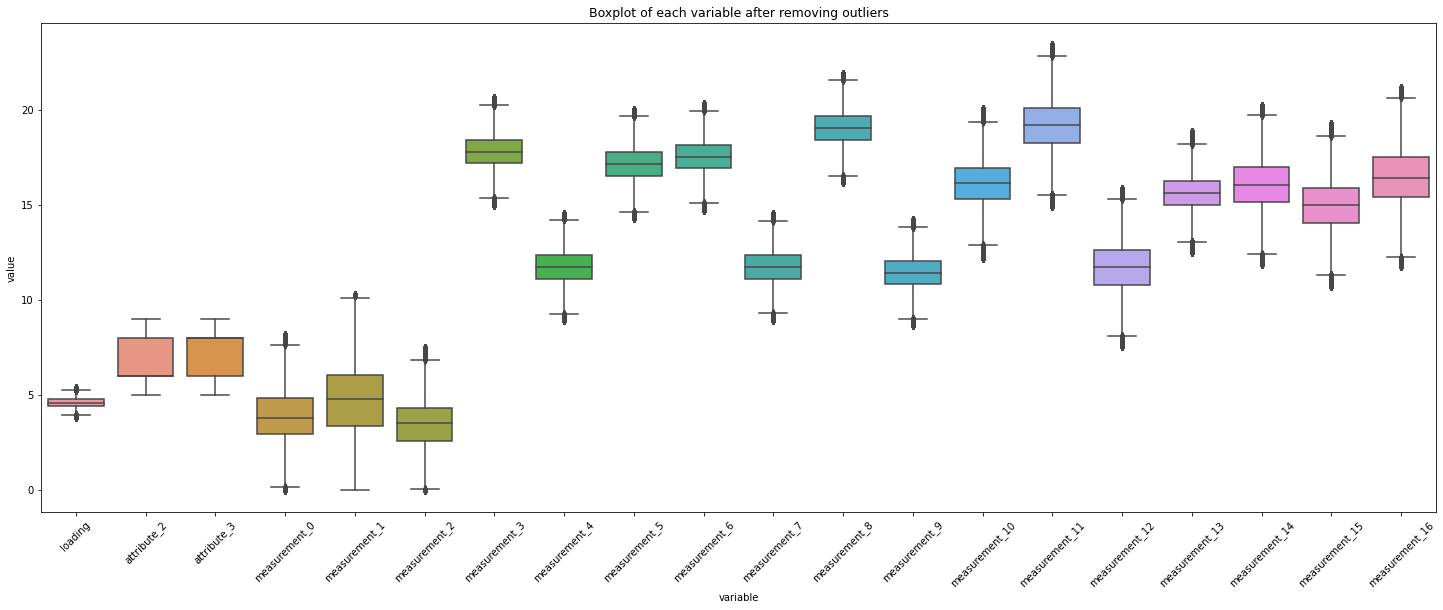

In [ ]:
dummy_df = pd.DataFrame(data = train_final, columns = train_final.columns[0:20])
plt.figure(figsize=(25,9))
sns.boxplot(x="variable", y="value", data=pd.melt(dummy_df)).set_title('Boxplot of each variable after removing outliers',size=12.5)
plt.xticks(rotation=45)
plt.savefig("outl2.png", dpi=300)

plt.show()

We are not including *measurement_17* in these boxplots for diagram scaling purposes.

In [ ]:
test_final = test_imp.copy()
for col in continuous:
    upper_l, lower_l = find_boundaries(test_final, col)
    test_final[col] = np.where(test_final[col] > upper_l, upper_l, np.where(test_final[col] < lower_l, lower_l, test_final[col]))

### 3.7. Standardising Variables


We standardise our data.

In [ ]:
scaler = StandardScaler()

#only makes sense in continous data
scaler.fit(train_final[continuous])

train_scaled = scaler.transform(train_final[continuous])
test_scaled = scaler.transform(test_final[continuous])

train_sc = pd.DataFrame(train_scaled, columns = continuous)
train_final[continuous] = train_sc
test_sc = pd.DataFrame(test_scaled, columns = continuous)
test_final[continuous] = test_sc
test_final.head()

,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,...,measurement_15,measurement_16,measurement_17,attribute_0_material_5,attribute_0_material_7,attribute_1_material_5,attribute_1_material_6,attribute_1_material_7,measurement_3_nan,measurement_5_nan
0,-0.169196,6.0,4.0,-0.257532,0.284529,0.023317,1.627522,-1.678121,0.421544,0.705928,...,-0.884934,0.809240,-0.582089,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.355189,6.0,4.0,0.936955,0.044815,-2.621613,0.095119,0.207409,0.094048,-1.614091,...,-0.153050,-1.507404,-1.403897,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.397991,6.0,4.0,0.257379,0.956284,-0.659402,0.733081,-1.351469,-0.557731,0.728748,...,1.467145,-0.275242,-0.376727,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.380173,6.0,4.0,0.257379,0.739319,1.166566,-1.375858,-0.912697,-1.976878,1.166671,...,-1.679105,-0.217455,-0.921601,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.802383,6.0,4.0,1.539833,1.769669,0.623400,0.014296,1.033205,0.575659,-1.852069,...,-1.180801,0.449672,0.819655,1.0,0.0,0.0,1.0,0.0,0.0,0.0


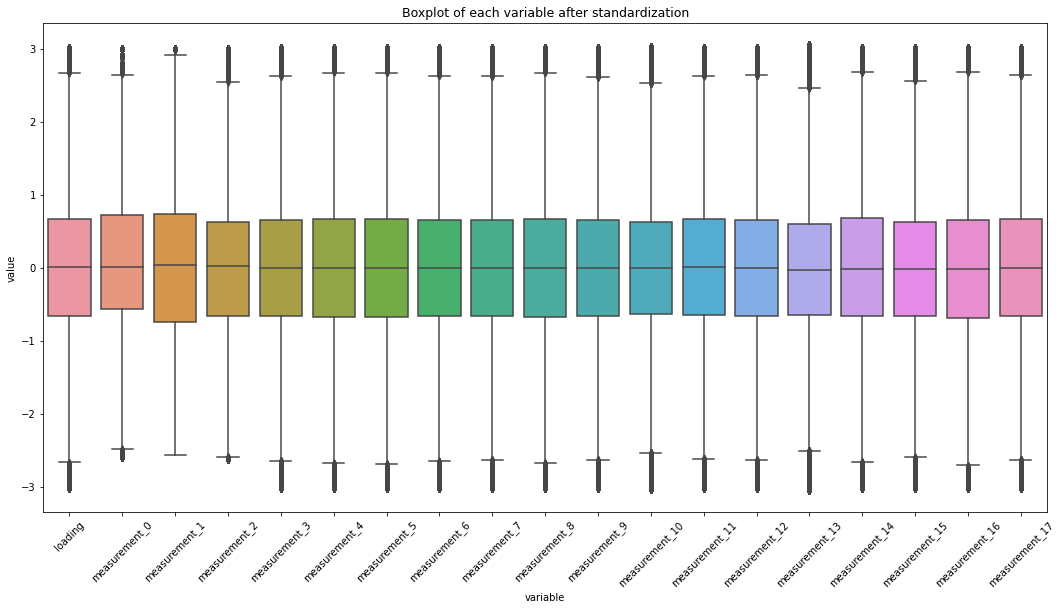

In [ ]:
dummy_df = pd.DataFrame(data = train_final[continuous], columns = continuous)
plt.figure(figsize=(18,9))
sns.boxplot(x="variable", y="value", data=pd.melt(dummy_df)).set_title('Boxplot of each variable after standardization',size=12.5)
plt.xticks(rotation=45)
plt.savefig("stan.png", dpi=300)

plt.show()

### Feature selection

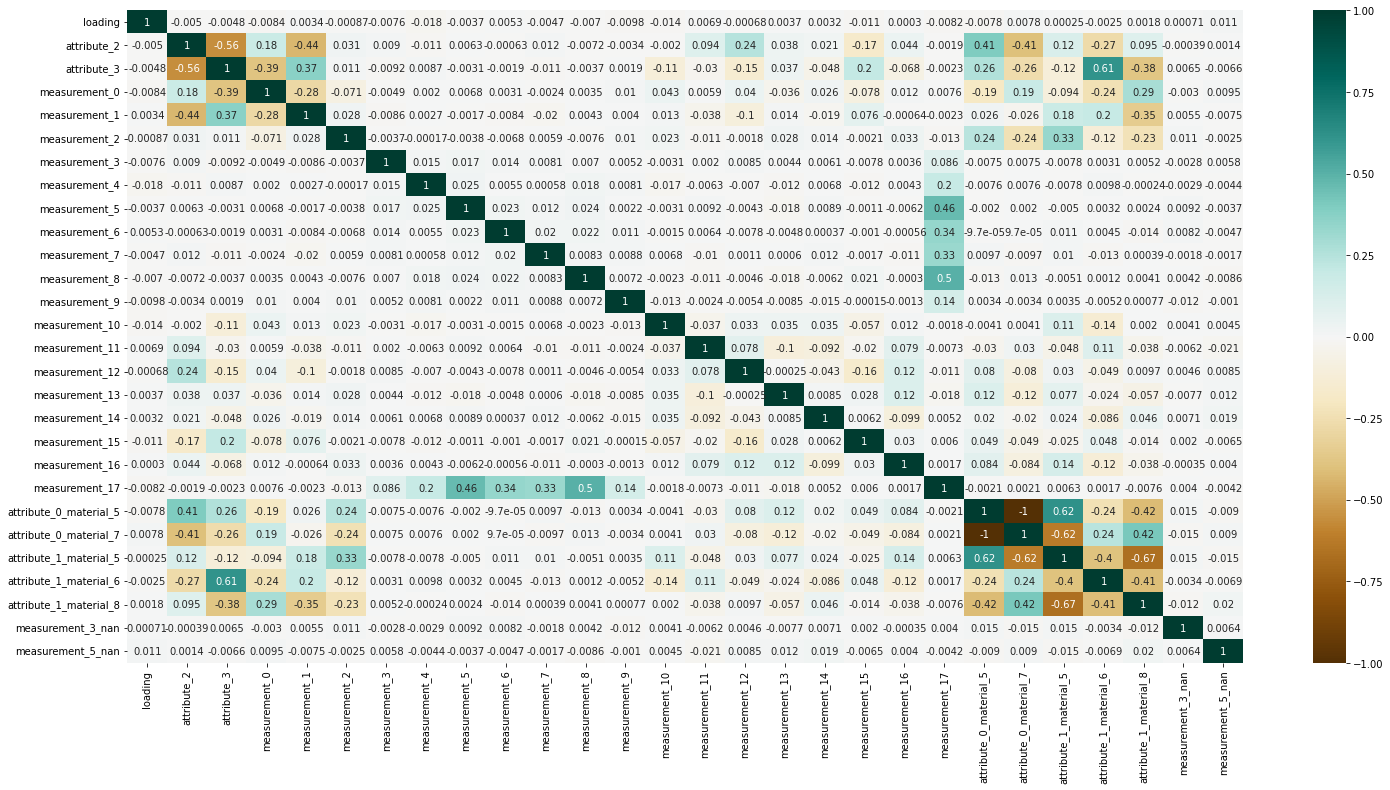

In [ ]:
corrMatrix = train_final.corr()
plt.figure(figsize=(25,12))
sns.heatmap(corrMatrix, cmap='BrBG', annot=True)
plt.savefig("covariance.png", dpi=400)
plt.show()

#### Feature selection with logistic regression

In [ ]:
X = train_final
y = np.ravel(y_resampled) #is not an array. It is a column in a dataset, so we use the NumPy np.ravel() function to convert that to an array.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [ ]:
#Instantiate the classifier
Logisticreg = LogisticRegression()
Logisticreg.fit(X_train, y_train)

# view the feature scores
feature_scores = pd.Series(Logisticreg.coef_[0], index=train_final.columns).sort_values(ascending=False)
feature_scores

loading                   0.337164
measurement_5_nan         0.172504
attribute_0_material_7    0.068299
measurement_2             0.054251
measurement_17            0.051183
attribute_1_material_6    0.026707
measurement_5             0.025160
measurement_8             0.021356
measurement_7             0.019697
measurement_0             0.018487
measurement_6             0.007199
attribute_2               0.005018
measurement_15            0.004681
measurement_3             0.003374
measurement_10            0.001391
measurement_16            0.000854
attribute_1_material_8   -0.001143
measurement_13           -0.003822
measurement_14           -0.004690
measurement_9            -0.006685
measurement_12           -0.007183
attribute_3              -0.011420
measurement_4            -0.014186
attribute_1_material_5   -0.014657
measurement_11           -0.015644
measurement_1            -0.029046
attribute_0_material_5   -0.057392
measurement_3_nan        -0.452685
dtype: float64

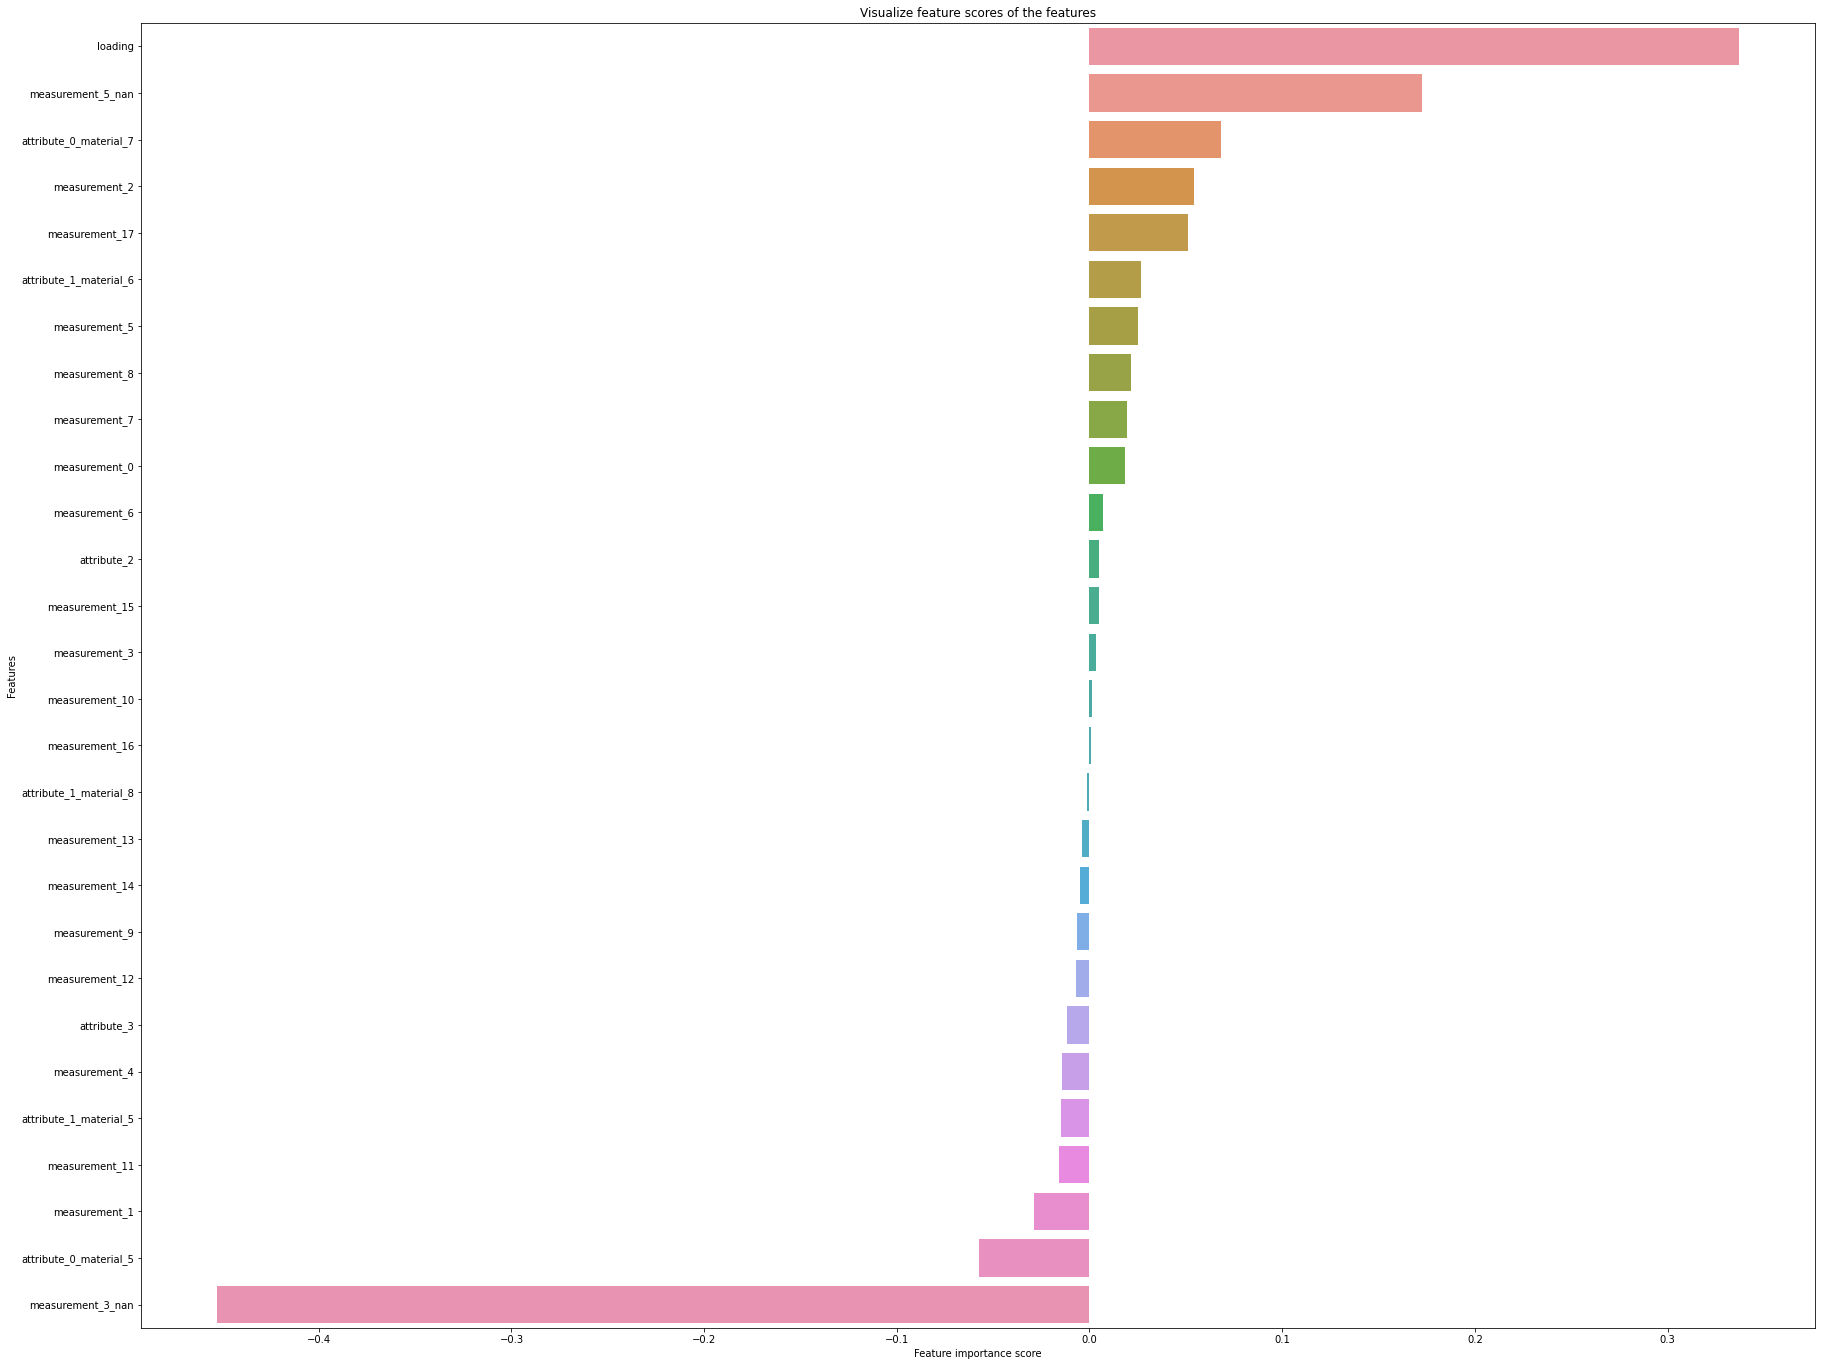

In [ ]:
# Creating a seaborn bar plot
f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=train)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.savefig("featureselect.png", dpi=300)
plt.show()

In our case we notice that measurement_3_nan, attribute_0_material 5 and measurement 11 have significant negative coefficients in the logistic regression model, it means that these variables impact our probability as follow: if they increase, the probability of having a 'failure' prototype decreases.

#### Recursive feature elimination with cross-validation


In [ ]:
min_features_to_select = 1  # Minimum number of features to consider
clf = LogisticRegression()
cv = StratifiedKFold(8)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(X_train, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 10


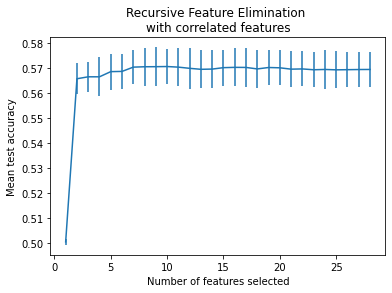

In [ ]:
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.savefig("seq_feat_sel1.png", dpi=300)
plt.show()

The cocnlusion of this isthat we should not take out varibales because the gain is not big enough. But maybe it is worth to train with 7 biggest ones.

In [ ]:
columns_7 = ['measurement_3_nan', 'attribute_0_material_5', 'measurement_17', 'loading', 'measurement_5_nan', 'attribute_0_material_7','measurement_2']
X_train_7 = X_train[columns_7]
X_test_7 = X_test[columns_7]

Use cross validation for every model, so to increase accuracy and avoid overfitting

## Champion Model: Logistic Regression Model

In [ ]:
Logisticreg = LogisticRegression()
Logisticreg.fit(X_train,y_train)
y_pred_logistic = Logisticreg.predict(X_test)

print("train accuracy:",Logisticreg.score(X_train,y_train))
print("test accuracy:",Logisticreg.score(X_test,y_test))
print(classification_report(y_test, y_pred_logistic))

train accuracy: 0.5709876543209876
test accuracy: 0.5723873441994247
              precision    recall  f1-score   support

           0       0.58      0.57      0.57      4219
           1       0.57      0.58      0.57      4125

    accuracy                           0.57      8344
   macro avg       0.57      0.57      0.57      8344
weighted avg       0.57      0.57      0.57      8344



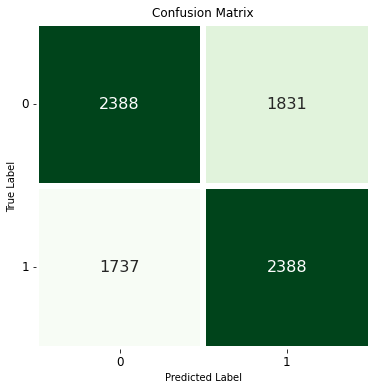

In [ ]:
cm = confusion_matrix(y_test, y_pred_logistic)
df1 = pd.DataFrame(columns=["0","1"], index= ["0","1"], data= cm )
f,ax = plt.subplots(figsize=(6,6))

sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',
            ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.title("Confusion Matrix", size = 12)
plt.show()

The Logistic regression model has approximately 57% accuracy. The confusion matrix provided us with some additional details. Each row in the matrix corresponds to a true label, and each column to a predicted label For the first class, we find 2381 samples, classified as class 0. However, 1703 samples in class 1 were confused with class 0. For the second class, we find 2447 samples, classified as class 1. However, 1813 samples in class 0 were confused with class 1.

In [ ]:
# in one analysis we found that the optimal number of parameterS was 7. That is the reason of existence of this cell.
Logisticreg.fit(X_train_7,y_train)
y_pred_logistic = Logisticreg.predict(X_train_7)
print("train accuracy:",Logisticreg.score(X_train_7,y_train))
print("test accuracy:",Logisticreg.score(X_test_7,y_test))

train accuracy: 0.5712873067241999
test accuracy: 0.5708293384467881


In this part we are using Stratified K-Folds cross-validator which will provide us train/test indices to split data in train/test sets.The data set is split and in each split model is created and predicted using that model. The final predicted value is average of all model.

In [ ]:
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
pred_test_full =0
cv_score =[]
i=1
y = y_resampled
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.iloc[train_index],X.iloc[test_index]
    ytr,yvl = y.iloc[train_index],y.iloc[test_index]

    #model
    lr = LogisticRegression(C=2)
    lr.fit(xtr,ytr)
    score = roc_auc_score(yvl,lr.predict(xvl))
    print('ROC AUC score:',score)
    cv_score.append(score)
    pred_test = lr.predict_proba(X_test)[:,1]
    pred_test_full +=pred_test
    i+=1

1 of KFold 5


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC AUC score: 0.5832933844678811
2 of KFold 5


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC AUC score: 0.5607109641447487
3 of KFold 5


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC AUC score: 0.5627481551497084
4 of KFold 5


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC AUC score: 0.5748532647810419
5 of KFold 5


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC AUC score: 0.5673021821447594


In [ ]:
print('Confusion matrix\n',confusion_matrix(yvl,lr.predict(xvl)))
print('Cv',cv_score,'\nMean cv Score',np.mean(cv_score))

Confusion matrix
 [[2375 1796]
 [1814 2358]]
Cv [0.5832933844678811, 0.5607109641447487, 0.5627481551497084, 0.5748532647810419, 0.5673021821447594] 
Mean cv Score 0.569781590137628


## Challenger Model 1: Random forest

In [ ]:
RFC = RandomForestClassifier()
RFC.fit(X_train,y_train)
y_pred_RFC = RFC.predict(X_test)
print("train accuracy:",RFC.score(X_train,y_train))
print("test accuracy:",RFC.score(X_test,y_test))
print(classification_report(y_test, y_pred_RFC))

train accuracy: 1.0
test accuracy: 0.8734419942473634
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      4219
           1       0.94      0.79      0.86      4125

    accuracy                           0.87      8344
   macro avg       0.88      0.87      0.87      8344
weighted avg       0.88      0.87      0.87      8344



Here we can see that the training accuracy is 100% but the validation accuracy is just 87% which is less compared to the case of training accuracy which means that the model is overfitting to the training data. To solve this problem first let’s use the parameter max_depth.

Max_depth represent the number of splits that each decision tree is allowed to make. If the number of splits is too low, the model underfits the data and if it is too high the model overfits.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(max_depth = 15)
RFC.fit(X_train,y_train)
y_pred_RFC_1 = RFC.predict(X_test)
print("train accuracy:",RFC.score(X_train,y_train))
print("test accuracy:",RFC.score(X_test,y_test))
print(classification_report(y_test, y_pred_RFC_1))

train accuracy: 0.9644911902193456
test accuracy: 0.8162751677852349
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      4219
           1       0.86      0.75      0.80      4125

    accuracy                           0.82      8344
   macro avg       0.82      0.82      0.82      8344
weighted avg       0.82      0.82      0.82      8344



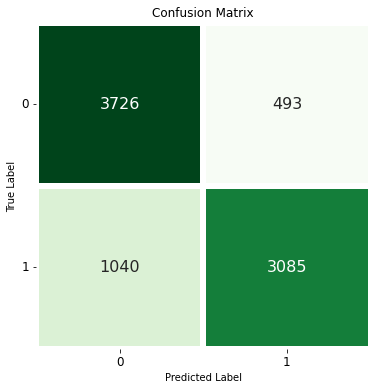

In [ ]:
cm = confusion_matrix(y_test, y_pred_RFC_1)
df1 = pd.DataFrame(columns=["0","1"], index= ["0","1"], data= cm )
f,ax = plt.subplots(figsize=(6,6))

sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',
            ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.title("Confusion Matrix", size = 12)
plt.show()

The RandomForestClassifier model has approximately 83% accuracy. The confusion matrix provided us with some additional details. Each row in the matrix corresponds to a true label, and each column to a predicted label For the first class, we find 3741 samples, classified as class 0. However, 982 samples in class 1 were confused with class 0. For the second class, we find 3168 samples, classified as class 1. However, 453 samples in class 0 were confused with class 1.

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
pred_test_full =0
cv_score =[]
i=1
y=y_resampled
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.iloc[train_index],X.iloc[test_index]
    ytr,yvl = y.iloc[train_index],y.iloc[test_index]

    #model
    RFC = RandomForestClassifier()
    RFC.fit(xtr,ytr)
    score = roc_auc_score(yvl,RFC.predict(xvl))
    print('ROC AUC score:',score)
    cv_score.append(score)
    pred_test = RFC.predict_proba(X_test)[:,1]
    pred_test_full +=pred_test
    i+=1


1 of KFold 5


<ipython-input-54-e6711474226f>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFC.fit(xtr,ytr)


ROC AUC score: 0.87248322147651
2 of KFold 5


<ipython-input-54-e6711474226f>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFC.fit(xtr,ytr)


ROC AUC score: 0.8640678124280949
3 of KFold 5


<ipython-input-54-e6711474226f>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFC.fit(xtr,ytr)


ROC AUC score: 0.8713796328711716
4 of KFold 5


<ipython-input-54-e6711474226f>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFC.fit(xtr,ytr)


ROC AUC score: 0.8803877811754586
5 of KFold 5


<ipython-input-54-e6711474226f>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFC.fit(xtr,ytr)


ROC AUC score: 0.8678037161582061


In [ ]:
print('Confusion matrix\n',confusion_matrix(yvl,RFC.predict(xvl)))
print('Cv',cv_score,'\nMean cv Score',np.mean(cv_score))

Confusion matrix
 [[3980  191]
 [ 912 3260]]
Cv [0.87248322147651, 0.8640678124280949, 0.8713796328711716, 0.8803877811754586, 0.8678037161582061] 
Mean cv Score 0.8712244328218881


## Challenger Model 2: XGBOOST

In [ ]:
model = xgboost.XGBClassifier()
model.fit(X_train,y_train)
y_pred_xgbst = model.predict(X_test)

In [ ]:
print("train accuracy:",model.score(X_train,y_train))
print("test accuracy:",model.score(X_test,y_test))
print(classification_report(y_test, y_pred_xgbst))

train accuracy: 0.8350413520316433
test accuracy: 0.8341323106423778
              precision    recall  f1-score   support

           0       0.76      0.99      0.86      4219
           1       0.99      0.67      0.80      4125

    accuracy                           0.83      8344
   macro avg       0.87      0.83      0.83      8344
weighted avg       0.87      0.83      0.83      8344



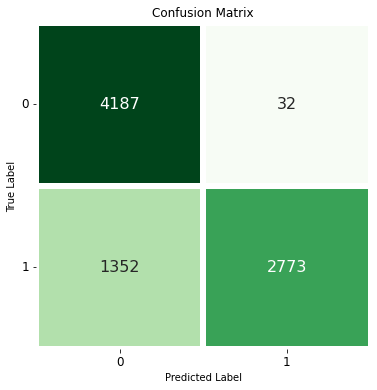

In [ ]:
cm = confusion_matrix(y_test, y_pred_xgbst)
df1 = pd.DataFrame(columns=["0","1"], index= ["0","1"], data= cm )
f,ax = plt.subplots(figsize=(6,6))

sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',
            ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.title("Confusion Matrix", size = 12)
plt.show()

The xgboost model has approximately 83% accuracy. The confusion matrix provided us with some additional details. Each row in the matrix corresponds to a true label, and each column to a predicted label For the first class, we find 4155 samples, classified as class 0. However, 1321 samples in class 1 were confused with class 0. For the second class, we find 2829 samples, classified as class 1. However, 39 samples in class 0 were confused with class 1.

In [ ]:
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
pred_test_full =0
cv_score =[]
i=1
y=y_resampled
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.iloc[train_index],X.iloc[test_index]
    ytr,yvl = y.iloc[train_index],y.iloc[test_index]

    #model
    model = xgboost.XGBClassifier()
    model.fit(xtr,ytr)
    score = roc_auc_score(yvl,model.predict(xvl))
    print('ROC AUC score:',score)
    cv_score.append(score)
    pred_test = model.predict_proba(X_test)[:,1]
    pred_test_full +=pred_test
    i+=1

1 of KFold 5


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC AUC score: 0.835810162991371
2 of KFold 5


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC AUC score: 0.824624087976309
3 of KFold 5


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC AUC score: 0.8342133385497683
4 of KFold 5


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC AUC score: 0.8342515538394241
5 of KFold 5


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC AUC score: 0.8329331550795993


In [ ]:
print('Confusion matrix\n',confusion_matrix(yvl,model.predict(xvl)))
print('Cv',cv_score,'\nMean cv Score',np.mean(cv_score))

Confusion matrix
 [[4147   24]
 [1370 2802]]
Cv [0.835810162991371, 0.824624087976309, 0.8342133385497683, 0.8342515538394241, 0.8329331550795993] 
Mean cv Score 0.8323664596872943


## Challenger Model 3: Support Machine Vector (SVM)


But as specified in the documentation, SVC fitting times scales quadratically with the number of samples. Thus, is recommended to use LinearSVC or SGDClassifier. Which means that the previous cells are not going to help us much because of time issue.

In [ ]:
svm=LinearSVC(C=0.0001)
svm.fit(X_train, y_train)
y_pred_svm = model.predict(X_test)
print("train accuracy:",svm.score(X_train,y_train))
print("test accuracy:",svm.score(X_test,y_test))
print(classification_report(y_test, y_pred_svm))

train accuracy: 0.5709876543209876
test accuracy: 0.5708293384467881
              precision    recall  f1-score   support

           0       0.76      0.99      0.86      4219
           1       0.99      0.68      0.80      4125

    accuracy                           0.84      8344
   macro avg       0.87      0.84      0.83      8344
weighted avg       0.87      0.84      0.83      8344



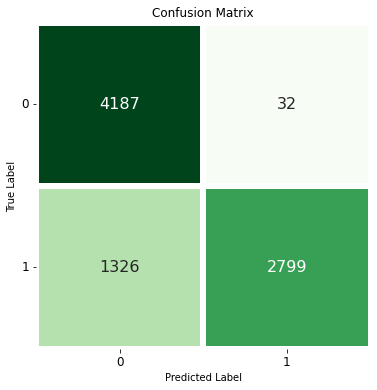

In [ ]:
cm = confusion_matrix(y_test, y_pred_svm)
df1 = pd.DataFrame(columns=["0","1"], index= ["0","1"], data= cm )
f,ax = plt.subplots(figsize=(6,6))

sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',
            ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.title("Confusion Matrix", size = 12)
plt.show()

The SVM model has approximately 57% accuracy. The confusion matrix provided us with some additional details.
Each row in the matrix corresponds to a true label, and each column to a predicted label
For the first class, we find 4161 samples, classified as class 0. However, 1304 samples in class 1 were confused with class 0.
For the second class, we find 2846 samples, classified as class 1. However, 33 samples in class 0 were confused with class 1.


In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
cv_score =[]
i=1
y=y_resampled
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.iloc[train_index],X.iloc[test_index]
    ytr,yvl = y.iloc[train_index],y.iloc[test_index]

    #model
    svm=LinearSVC(C=0.0001)
    svm.fit(xtr, ytr)
    score = roc_auc_score(yvl, svm.predict(xvl))
    print('ROC AUC score:',score)
    cv_score.append(score)
    i+=1

1 of KFold 5
ROC AUC score: 0.5818552253116012
2 of KFold 5


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC AUC score: 0.5603512519558758
3 of KFold 5


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC AUC score: 0.5611894023312591
4 of KFold 5


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC AUC score: 0.5773705317706402
5 of KFold 5
ROC AUC score: 0.5665833611663238


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print('Confusion matrix\n',confusion_matrix(yvl,svm.predict(xvl)))
print('Cv',cv_score,'\nMean cv Score',np.mean(cv_score))

Confusion matrix
 [[2384 1787]
 [1829 2343]]
Cv [0.5818552253116012, 0.5603512519558758, 0.5611894023312591, 0.5773705317706402, 0.5665833611663238] 
Mean cv Score 0.56946995450714


## Challenger Model 4: NN

In [ ]:
seed = 7
np.random.seed(seed)

In [ ]:
# Model example : give reasons to choose this structure --> magic
model = Sequential()
model.add(Dense(200, input_dim=28, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(75, kernel_initializer='normal', activation='relu'))
model.add(Dense(50, kernel_initializer='normal', activation='relu'))
model.add(Dense(25, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# Compile model
model.compile(loss='mean_squared_error', optimizer="nadam", metrics=[["mean_absolute_error"], ["accuracy"]])
# save it
history=model.fit(X, y, epochs=150, batch_size=70, validation_split=0.3)


Epoch 1/150
418/418 [==============================] - 4s 6ms/step - loss: 0.2023 - mean_absolute_error: 0.3953 - accuracy: 0.7135 - val_loss: 0.5982 - val_mean_absolute_error: 0.7714 - val_accuracy: 0.0000e+00
Epoch 2/150
418/418 [==============================] - 2s 5ms/step - loss: 0.1981 - mean_absolute_error: 0.3931 - accuracy: 0.7131 - val_loss: 0.2178 - val_mean_absolute_error: 0.4566 - val_accuracy: 0.6962
Epoch 3/150
418/418 [==============================] - 2s 4ms/step - loss: 0.1957 - mean_absolute_error: 0.3903 - accuracy: 0.7154 - val_loss: 0.5436 - val_mean_absolute_error: 0.7344 - val_accuracy: 7.9904e-05
Epoch 4/150
418/418 [==============================] - 2s 5ms/step - loss: 0.1938 - mean_absolute_error: 0.3871 - accuracy: 0.7172 - val_loss: 0.4431 - val_mean_absolute_error: 0.6589 - val_accuracy: 0.0410
Epoch 5/150
418/418 [==============================] - 2s 5ms/step - loss: 0.1919 - mean_absolute_error: 0.3831 - accuracy: 0.7201 - val_loss: 0.3504 - val_mean_abs

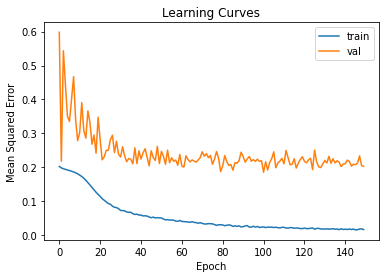

In [ ]:
# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

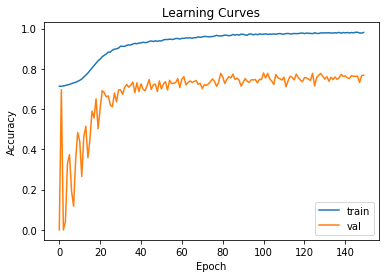

In [ ]:
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.savefig("nn_model1_act1.png", dpi=300)
plt.show()

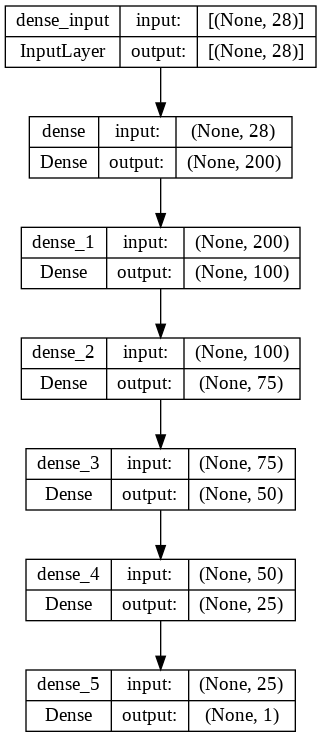

In [ ]:
plot_model(model, to_file='/tmp/model1.png', show_shapes=True,)

In [ ]:
score = model.evaluate(X_train, y_train ,verbose=1)
print(score)

1043/1043 [==============================] - 3s 2ms/step - loss: 0.0704 - mean_absolute_error: 0.0984 - accuracy: 0.9190
[0.07041644304990768, 0.09838183969259262, 0.9190307855606079]


Now we will try a different architecture.

In [ ]:
n_inputs = 28
model = Sequential([
    Input(shape=(n_inputs,)),
    Dense(512, activation='selu', kernel_initializer = 'HeNormal'),
    Dropout(0.3),
    Dense(258, activation='selu', kernel_initializer = 'HeNormal'),
    BatchNormalization(),
    Dense(128, activation='selu'),
    Dropout(0.2),
    Dense(64, activation='selu', kernel_initializer = 'HeNormal'),
    BatchNormalization(),
    Dense(32, activation='selu'),
    Dense(units=1, activation="sigmoid")
])
# Compile model
model.compile(loss='mean_squared_error', optimizer="nadam", metrics=[["mean_absolute_error"], ["accuracy"]])
# save it
history=model.fit(X, y, epochs=150, batch_size=70, validation_split=0.3)


Epoch 1/150
418/418 [==============================] - 13s 23ms/step - loss: 0.2122 - mean_absolute_error: 0.4016 - accuracy: 0.6937 - val_loss: 0.4251 - val_mean_absolute_error: 0.6473 - val_accuracy: 0.0332
Epoch 2/150
418/418 [==============================] - 6s 14ms/step - loss: 0.2023 - mean_absolute_error: 0.3963 - accuracy: 0.7118 - val_loss: 0.4911 - val_mean_absolute_error: 0.6955 - val_accuracy: 0.0106
Epoch 3/150
418/418 [==============================] - 7s 16ms/step - loss: 0.2006 - mean_absolute_error: 0.3944 - accuracy: 0.7133 - val_loss: 0.4312 - val_mean_absolute_error: 0.6478 - val_accuracy: 0.1066
Epoch 4/150
418/418 [==============================] - 8s 18ms/step - loss: 0.1995 - mean_absolute_error: 0.3931 - accuracy: 0.7144 - val_loss: 0.4472 - val_mean_absolute_error: 0.6642 - val_accuracy: 0.0120
Epoch 5/150
418/418 [==============================] - 9s 21ms/step - loss: 0.1975 - mean_absolute_error: 0.3906 - accuracy: 0.7145 - val_loss: 0.3807 - val_mean_absol

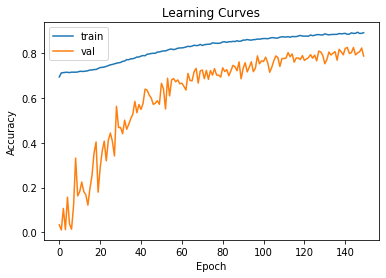

In [ ]:
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.savefig("nn_model2_act2.png", dpi=300)
plt.show()

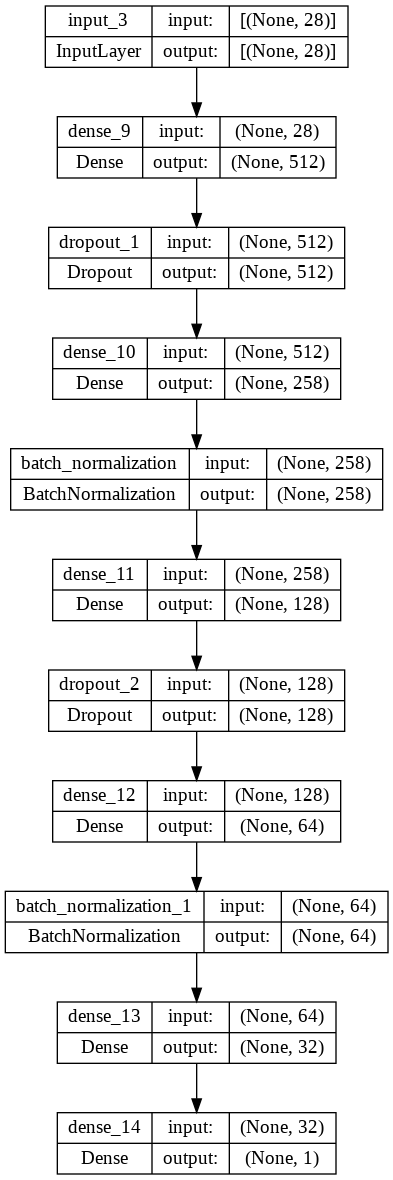

In [ ]:
plot_model(model, to_file='/tmp/model2.png', show_shapes=True,)

We propose a continuation a way of implementing a NN with both crossvalidation and early stopping. It relies in what we have seen early. We have commented it because it is more for explanatory purposes.

In [ ]:
"""
optimizer = #choose optimizer
metrics = #choose metric
class_weight = #determine your weights

early_stopping = EarlyStopping(patience=20, min_delta=1e-5, restore_best_weights=True)
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.iloc[train_index],X.iloc[test_index]
    ytr,yvl = y.iloc[train_index],y.iloc[test_index]
    model.compile(loss=loss, optimizer = optimizer, metrics=metrics)
    model.fit(X_tr, y_tr,
              batch_size = batch_size,
              epochs =epoch,
              validation_data=(X_val, y_val),
              callbacks=[early_stopping],
             class_weight=class_weight,
              verbose=0 ,
             )
    val_pred = model.predict(X_val)
    score = roc_auc_score(y_val,val_pred)
    scores.append(score)
    print(f"Fold: {fold + 1} roc_auc Score is : {score}")
    print('*'*40)

"""
